# Umpire Lifes Lengths

Data was acquired at this website: https://cran.r-project.org/web/packages/Sleuth2/Sleuth2.pdf

#### Description of the Dataset, from the Documentation:
Researchers collected historical and current data on umpires to investigate their life expectancies following the collapse and death of a U.S. major league baseball umpire. They were investigating speculation that stress associated with the job posed a health risk. Data were found on 227 umpires who had died or had retired and were still living. 

#### Variables:
* Lifelength: observed lifetime for those umpires who had died by the time of the study or current age of those still living
* Censored: 0 for those who had died by the time of the study or 1 for those who were still living
* Expected: length from actuarial life tables for individuals who were alive at the time the person first became an umpire

### Given information about life expectancy and age (or age at time of death), can we create a model that predicts wether or not an umpire is alive or dead?

In [1]:
install.packages('Sleuth2')
library(Sleuth2)
# help(ex0321) # Uncomment if you want to look at information about this dataset

install.packages("roccv")
library(roccv)


The downloaded binary packages are in
	/var/folders/vl/cvrbggss5jl47s3xcs4y5jr00000gn/T//RtmpOopv47/downloaded_packages


also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘plyr’, ‘glmnet’, ‘pROC’





The downloaded binary packages are in
	/var/folders/vl/cvrbggss5jl47s3xcs4y5jr00000gn/T//RtmpOopv47/downloaded_packages


Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 3.0-2


Loading required package: parallel

Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




Here, I fit two models. 

1. Censored on Expected
2. Censored on Expected + Expected squared

The plot below shows how the models predict if the umpire is alive or dead. 

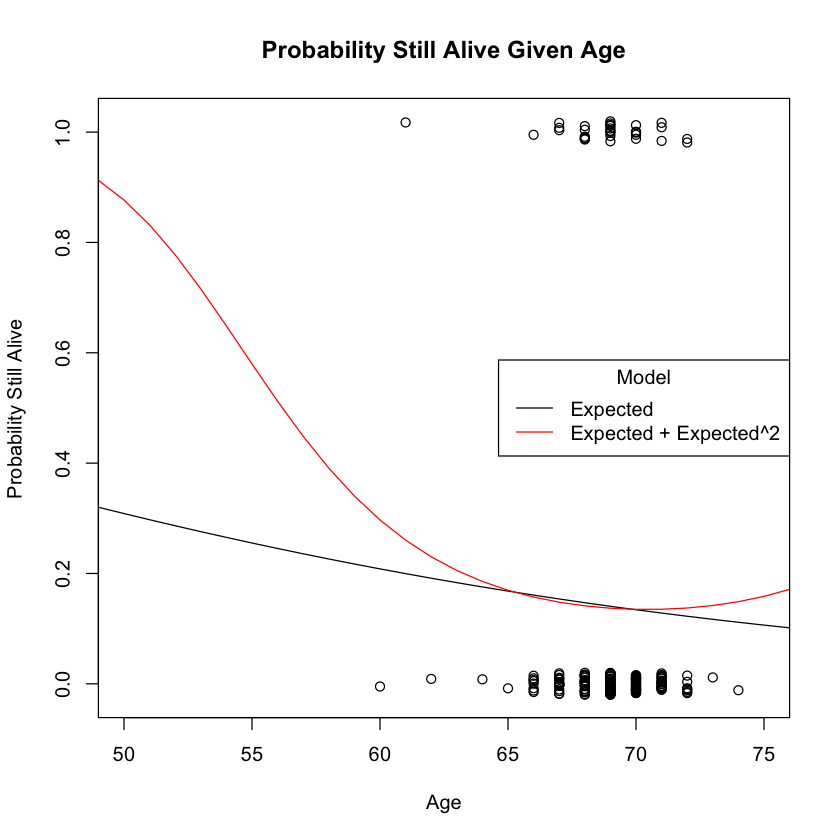

In [2]:
# Fit the models
g_lin <- glm(Censored ~ Expected, data=ex0321, family="binomial")
g_quad <- glm(Censored ~ Expected + I(Expected^2), data=ex0321, family="binomial")

# Plot data and add prediction lines
with(ex0321, plot(Expected, jitter(Censored, factor = .1), xlim = c(50,75), ylab = "Probability Still Alive", 
                  xlab = "Age", main = "Probability Still Alive Given Age"))
pred_life <- seq(0,100) # ages to predict on
lin_preds <- predict(g_lin, newdata=data.frame(Expected=pred_life), family="binomial", type="response")
quad_preds <- predict(g_quad, newdata=data.frame(Expected=pred_life), family="binomial", type="response")
lines(pred_life, lin_preds)
lines(pred_life, quad_preds, col=2)
legend("right", c("Expected", "Expected + Expected^2"), lty=1, col=c(1,2), title = "Model")

Here, our model that included Expected squred seems to fit the data better than the linear model. To see if I can make the model even better, I will add Lifelength as a variable. I have two new models:

1. Censored on Expected + Lifelength
2. Censored on Expected + Expected squared + Lifelength

The plot below shows how the models predict if the umpire is alive or dead.

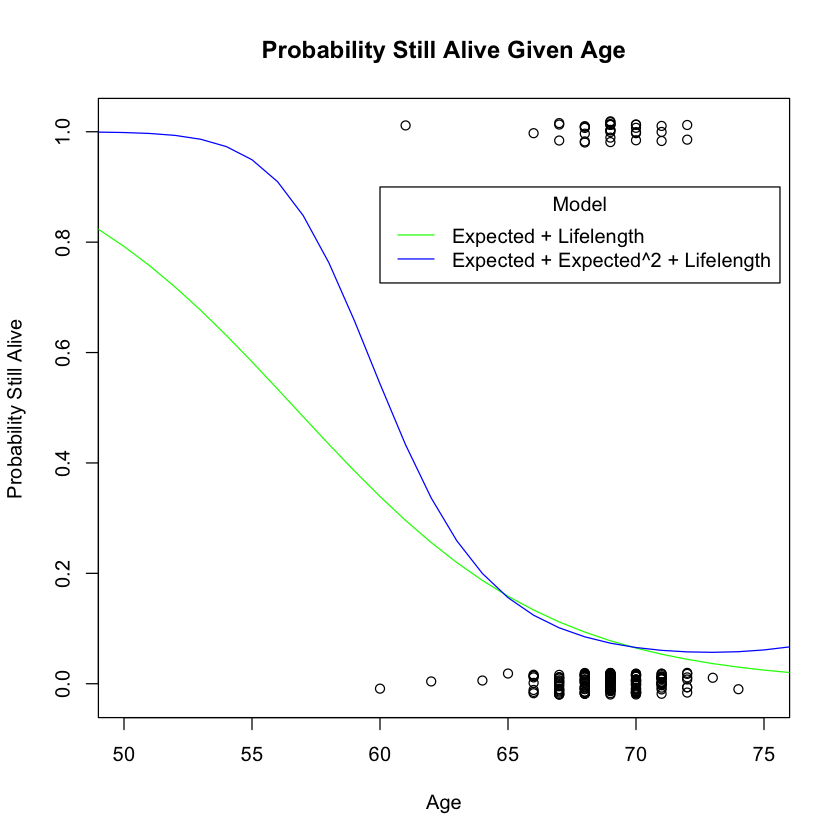

In [6]:
# Fit the models
g_lin_adv <- glm(Censored ~ Expected + Lifelength, data=ex0321, family="binomial")
g_quad_adv <- glm(Censored ~ Expected + I(Expected^2) + Lifelength, data=ex0321, family="binomial")

# Plot data and add prediction lines
with(ex0321, plot(Expected, jitter(Censored, factor = .1), xlim = c(50,75), ylab = "Probability Still Alive", 
                  xlab = "Age", main = "Probability Still Alive Given Age"))
pred_life <- seq(0,100) # ages to predict on
lin_preds <- predict(g_lin_adv, newdata = data.frame(Expected=pred_life, Lifelength = pred_life), family="binomial", type="response")
quad_preds <- predict(g_quad_adv, newdata = data.frame(Expected=pred_life, Lifelength = pred_life), family="binomial", type="response")
lines(pred_life, lin_preds, col = "green") # Colors changed for consistency with AUC plots below
lines(pred_life, quad_preds, col = "blue")
legend(60,.9, c("Expected + Lifelength", "Expected + Expected^2 + Lifelength"), lty=1, col=c("green", "blue"), title = "Model")

This appear to be an improvement on the previous model. To confirm this, I will run 10-fold cross validation on each of these models and asses the sensitivity and specificity of each by calculating the area under the ROC curve (AUC).

This curve can be thought of as displaying the trade-off between sensitivity and specificity. If we want to be more specific, we typically must sacrifice sensitivity and vice-versa. A higher AUC indicates that there is less of a trade-off. An AUC score of 1 indicates perfect sensitivity and specificity, where an AUC score of .5 indicates random guessing. 

Here, **Sensitivity** is correctly identifying that the umpire is still living. **Specificity** is correctly identifying that the umpire has died. 

In [4]:
ex0321a<-subset(ex0321, is.na(Expected)==FALSE, is.na(Lifelength)==FALSE)
n<- dim(ex0321)[-1]
set.seed(1865)
fold_assignment <- randomly_assign(n,10)

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1



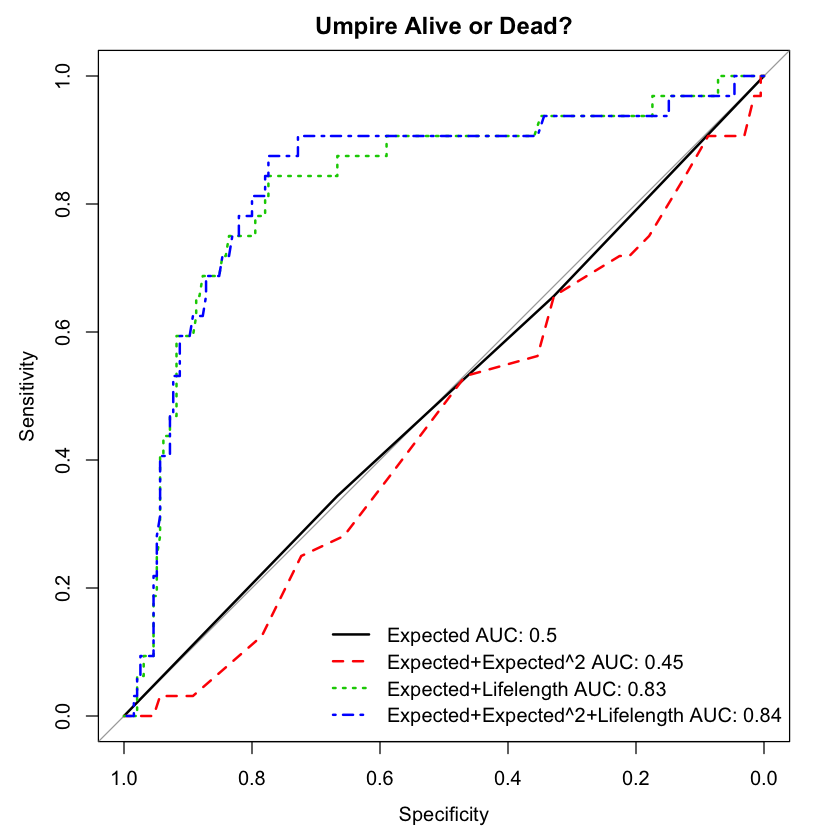

In [7]:
lin_cv <- cv(model.matrix(g_lin)[,-1],y=ex0321$Censored, data=ex0321, method_name="Expected", folds=fold_assignment)
quad_cv <- cv(model.matrix(g_quad)[,-1],y=ex0321$Censored, data=ex0321, method_name="Expected+Expected^2", folds=fold_assignment)
lin_adv_cv <- cv(model.matrix(g_lin_adv)[,-1], y=ex0321$Censored, data=ex0321, method_name="Expected+Lifelength", folds=fold_assignment)
quad_adv_cv <- cv(model.matrix(g_quad_adv)[,-1], y=ex0321$Censored, data=ex0321, method_name="Expected+Expected^2+Lifelength", folds=fold_assignment)
rocplot(rbind(lin_cv, quad_cv, lin_adv_cv, quad_adv_cv), main = "Umpire Alive or Dead?")

The blue line is $Expected + Expected^2 + Lifelength$ with an AUC of .84.

The green line is $Expected + Lifelength$ with an AUC of .83

The red line is $Expected + Expected^2$ with an AUC of .45.

The black line is the $Expected$ only with an AUC of .5.

The model that reduces AUC the most, and gives us a specificity and sensitivity as close to 1 as possible, is the $Expected + Expected^2 + Lifelength$ model. Therefore, this is our best model for predicting if a given umpire is alive or dead. 